# Training

In [1]:
import torch
import random

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data

from transforms import train_transforms
from dataset import ContrastiveLearningDataset

/home/aleksandra/Documents/hackathon/knum_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [2]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [3]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


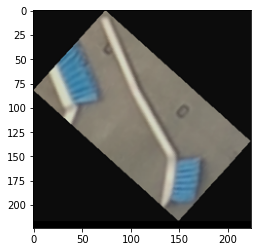

In [4]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)
img = T.Resize(224)(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [5]:
images = df['img']
labels = df['category_id']

val_labels = [4, 10]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [6]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)

(-1, 0.2222222222222222)

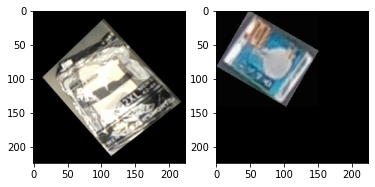

In [7]:
id_ = random.randrange(0, len(train_dataset))

image_1, image_2, sign, weight = train_dataset[id_]

f, axarr = plt.subplots(1,2) 

axarr[0].imshow(image_1.permute(1, 2, 0))
axarr[1].imshow(image_2.permute(1, 2, 0))

sign, weight

In [8]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
)

## Training loop

In [9]:
EPOCHS = 10

In [10]:
from ipynb.fs.full.fb_model_extractor import DeiTForImageClassificationWithTeacher
from transformers import AutoFeatureExtractor

torch.Size([1, 384])


In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-small-distilled-patch16-224') # TODO to nie jest dotrenowywane
model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-small-distilled-patch16-224')
optimizer = torch.optim.Adam(model.parameters())

In [12]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

def contrastive_learning_loss(v_1, v_2, weight, sign):
    cos_sim = cos(v_1, v_2)
    loss = - weight * cos_sim * sign
    return loss.mean()

In [13]:
for epoch in range(EPOCHS):
    losses = []
    for i, data in enumerate(train_loader, 0):
        image_1, image_2, sign, weight = data
        # image_1 = Image.fromarray((image_1 * 255).astype(np.uint8))
        # image_2 = Image.fromarray((image_2 * 255).astype(np.uint8))
        # print(image_1)
        v_1 = model(**feature_extractor(image_1))
        v_2 = model(**feature_extractor(image_2))
        
        loss = contrastive_learning_loss(v_1, v_2, weight, sign)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE

/home/aleksandra/Documents/hackathon/knum_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


tensor([[[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],

         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],

         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  7,   7,   7,  ...,   0,   0,   0],
          [  7,   7,   7,  ...,   0

TypeError: Cannot handle this data type: (1, 1, 224, 224), |u1